# 1. Google Trend를 활용한 대학별 검색량 추출

In [1]:
!pip install pytrends
!pip install geopy
!pip install pyproj
!pip install folium
!pip install scikit-learn
!pip install threadpoolctl
!pip install numpy scipy

In [2]:
import folium
import pyproj
import math
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import pandas as pd
from pytrends.request import TrendReq
import re
from geopy.geocoders import Nominatim
from scipy import stats
import statsmodels.api as sm
import threadpoolctl

## 대학 정보 획득 및 대학 명 추출

In [3]:
# 대학 정보 CSV 파일
univ_list = pd.read_csv('서울시 대학 및 전문대학 DB 정보 (한국어).csv',encoding='EUC-KR')
# 상권 정보 CSV 파일
commercial_area_list = pd.read_csv('서울시 상권분석서비스(상권영역).csv',encoding='EUC-KR')
commercial_area_store_type_list = pd.read_csv('서울시 상권분석서비스(상권-점포).csv',encoding='EUC-KR')
print(univ_list)
print(commercial_area_list)
print(commercial_area_store_type_list)

                키값    연도      학교종류        학교명    본분교   학교상태     설립  우편번호  \
0   BE_LiST23-0034  2013      일반대학    서울시립대학교     본교     기존     공립   NaN   
1   BE_LiST23-0036  2013      일반대학    서울여자대학교     본교     기존     사립   NaN   
2   BE_LiST23-0038  2013      일반대학     성공회대학교     본교     기존     사립   NaN   
3   BE_LiST23-0039  2013      일반대학     성균관대학교     본교     기존     사립   NaN   
4   BE_LiST23-0040  2013      일반대학    성신여자대학교     본교     기존     사립   NaN   
5   BE_LiST23-0041  2013      일반대학      세종대학교     본교     기존     사립   NaN   
6   BE_LiST23-0042  2013      일반대학    숙명여자대학교     본교     기존     사립   NaN   
7   BE_LiST23-0043  2013      일반대학      숭실대학교     본교     기존     사립   NaN   
8   BE_LiST23-0045  2013      일반대학      연세대학교     본교     기존     사립   NaN   
9   BE_LiST23-0046  2013      일반대학    이화여자대학교     본교     기존     사립   NaN   
10  BE_LiST23-0048  2013      일반대학   장로회신학대학교     본교     기존     사립   NaN   
11  BE_LiST23-0050  2013      일반대학      중앙대학교     본교     기존     사립   NaN   
12  BE_LiST2

In [4]:
univ_name_n_search = univ_list[["학교명", "주소", "행정구", "행정동"]].copy() # 학교 이름 및 주소 추출
univ_name_n_search.loc[univ_name_n_search["학교명"] == '국제예술대학', '학교명'] = '국제예술대학교' # 국제예술대학 예외처리
univ_name_n_search = univ_name_n_search.drop(index=[22, 23]) # 동일이름 처리
print(univ_name_n_search)


          학교명                                주소   행정구          행정동
0     서울시립대학교    서울 동대문구 서울시립대로 163 (전농동 90번지)   동대문구         휘경2동
1     서울여자대학교         서울특별시 노원구 화랑로 621 서울여자대학교   노원구         공릉2동
2      성공회대학교                  서울 구로구 항동 성공회대학교   구로구         오류2동
3      성균관대학교               서울 종로구 명륜동3가 성균관대학교   종로구  종로1.2.3.4가동
4     성신여자대학교              서울 성북구 동선동3가 성신여자대학교   성북구          동선동
5       세종대학교                  서울 광진구 군자동 세종대학교   광진구          군자동
6     숙명여자대학교         서울 용산구 청파로47길 100 숙명여자대학교   용산구          청파동
7       숭실대학교              서울 동작구 상도동 511 숭실대학교   동작구         상도1동
8       연세대학교                 서울 서대문구 신촌동 연세대학교  서대문구          신촌동
9     이화여자대학교          서울 서대문구 대현동 11-1 이화여자대학교  서대문구          신촌동
10   장로회신학대학교  서울 광진구 광장로 5길 25-1(광장동) 장로회신학대학교   광진구          광장동
11      중앙대학교                     서울 동작구 흑석로 84   동작구          흑석동
12      총신대학교                  서울 동작구 사당동 산31-3   동작구         사당3동
13    추계예술대학교        서울 서대문구 북아현동 190-1 추계예술대학교  서대문구         

In [5]:
# 검색량 추출 함수
def add_search_volume(df, start_date, end_date):
    # Google Trends API에 접속하기 위한 객체 생성
    pytrends = TrendReq(hl='ko-KR', tz=540)

    # 새 열 추가
    df['검색량'] = 0

    for index, row in df.iterrows():
        keyword = row['학교명']  # 검색어 설정
        
        # 검색어 설정 및 검색 기간 설정
        pytrends.build_payload(kw_list=[keyword], timeframe=f'{start_date} {end_date}')

        # 구글 트렌드 검색량 데이터 가져오기
        interest_over_time_df = pytrends.interest_over_time()
        univ_count = interest_over_time_df[keyword].sum()

        # 검색량 데이터를 데이터프레임에 추가
        df.at[index, '검색량'] = univ_count

    return df

In [6]:
# 대학 약칭 처리를 위한 학교명 변경 함수 정의
def rename_university(name):
    if name.endswith('여자대학교'):
        return name.replace('여자대학교', '여대')
    elif name.endswith('예술대학교'):
        return name.replace('예술대학교', '예대')
    elif name.endswith('외국어대학교'):
        return name.replace('외국어대학교', '외대')
    elif name.endswith('체육대학교'):
        return name.replace('체육대학교', '체대')
    elif name.endswith('교육대학교'):
        return name.replace('교육대학교', '교대')
    else:
        return name.replace('대학교', '대')

def rename_university_to_origin(row):
    name = row["학교명"]
    normal_pattern = r'^(.*?[가-힣]{2})대$'
    if name.endswith('여대'):
        return name.replace('여대', '여자대학교')
    elif name.endswith('예대'):
        return name.replace('예대', '예술대학교')
    elif name.endswith('외대'):
        return name.replace('외대', '외국어대학교')
    elif name.endswith('한국체대'):
        return name.replace('한국체대', '한국체육대학교')
    elif name.endswith('체대'):
        return name.replace('체대', '체육대학교')
    elif name.endswith('교대'):
        return name.replace('교대', '교육대학교')
    else:
        match = re.match(normal_pattern, name)
        if match:
            return match.group(1) + '대학교'
    return name


## 각 대학별 검색량 획득
google trend 기반의 검색량 획득

In [7]:
# 검색 기간 설정
start_date = '2022-06-01'  # 시작 날짜 설정
end_date = '2023-06-01'  # 종료 날짜 설정

# 검색량 정보 추가 및 결과 출력
add_search_volume(univ_name_n_search, start_date, end_date)
univ_name_n_search = univ_name_n_search.sort_values('검색량',ascending = False)
print(univ_name_n_search)

          학교명                                주소   행정구          행정동   검색량
45      서울대학교                서울 관악구 관악로 1 서울대학교   관악구         낙성대동  4106
11      중앙대학교                     서울 동작구 흑석로 84   동작구          흑석동  3913
19      한양대학교               서울특별시 성동구 왕십리로 222    성동구          사근동  3653
27      경희대학교                 서울 동대문구 회기동 경희대학교  동대문구          회기동  3514
28      고려대학교                  서울 성북구 안암동 고려대학교   성북구          안암동  3497
3      성균관대학교               서울 종로구 명륜동3가 성균관대학교   종로구  종로1.2.3.4가동  3470
5       세종대학교                  서울 광진구 군자동 세종대학교   광진구          군자동  3465
8       연세대학교                 서울 서대문구 신촌동 연세대학교  서대문구          신촌동  3338
0     서울시립대학교    서울 동대문구 서울시립대로 163 (전농동 90번지)   동대문구         휘경2동  3330
36      명지대학교                 서울 서대문구 남가좌동 50-3  서대문구        남가좌2동  3302
40      서강대학교                  서울 마포구 신수동 서강대학교   마포구          대흥동  3267
38      삼육대학교       서울시 노원구 화랑로 815(공릉2동 26-21)   노원구         공릉2동  3262
25      건국대학교                        서울 광진구 화양동   광

## 대학별 다른이름 처리

In [8]:
univ_diff_name = univ_name_n_search[["학교명"]].copy()
# 학교명 변경 적용
univ_diff_name['학교명'] = univ_diff_name['학교명'].apply(rename_university)

# 행 추가
univ_diff_name = pd.concat([univ_diff_name, pd.DataFrame({'학교명': ['홍대', '건대','한체대', '한예종']})], ignore_index=True)

# 변경된 데이터프레임 출력
print(univ_diff_name)

         학교명
0        서울대
1        중앙대
2        한양대
3        경희대
4        고려대
5       성균관대
6        세종대
7        연세대
8      서울시립대
9        명지대
10       서강대
11       삼육대
12       건국대
13      한국외대
14       국민대
15       동국대
16       숭실대
17       상명대
18       한성대
19      숙명여대
20       경기대
21       서경대
22      이화여대
23      서울여대
24       광운대
25      덕성여대
26   서울과학기술대
27      동덕여대
28    장로회신학대
29       홍익대
30      서울교대
31  한국예술종합학교
32      백석예대
33      한국체대
34      성공회대
35     한국성서대
36       총신대
37      성신여대
38    감리교신학대
39      추계예대
40      국제예대
41     서울기독대
42     그리스도대
43     한영신학대
44        홍대
45        건대
46       한체대
47       한예종


In [9]:
oops = ["장로회신학대","한영신학대","감리교신학대","서울기독대", "한국예술종합학교"] # api 에러가 발생하는 학교명 및 별명이 처리되지 않은 학교명 삭제, 검색량 문제
univ_diff_name = univ_diff_name.drop(univ_diff_name[univ_diff_name["학교명"].isin(oops)].index)
add_search_volume(univ_diff_name, start_date, end_date)
univ_diff_name = univ_diff_name.sort_values('검색량',ascending = False)
# print(univ_diff_name)
univ_diff_name["학교명"] = univ_diff_name.apply(rename_university_to_origin, axis=1)
print(univ_diff_name)

          학교명   검색량
44         홍대  4147
0       서울대학교  3772
7       연세대학교  3730
45         건대  3715
4       고려대학교  3657
5      성균관대학교  3368
1       중앙대학교  3252
18      한성대학교  3234
3       경희대학교  3197
2       한양대학교  3130
47        한예종  3030
6       세종대학교  3027
36      총신대학교  2989
34     성공회대학교  2940
22    이화여자대학교  2935
30    서울교육대학교  2926
17      상명대학교  2782
10      서강대학교  2767
16      숭실대학교  2763
37    성신여자대학교  2751
14      국민대학교  2729
20      경기대학교  2728
9       명지대학교  2711
23    서울여자대학교  2699
27    동덕여자대학교  2650
25    덕성여자대학교  2621
15      동국대학교  2620
12      건국대학교  2543
19    숙명여자대학교  2521
24      광운대학교  2492
29      홍익대학교  2394
21      서경대학교  2357
32    백석예술대학교  2225
8     서울시립대학교  2115
11      삼육대학교  2064
46     한체육대학교  1712
26  서울과학기술대학교  1518
39    추계예술대학교  1334
40    국제예술대학교  1286
33    한국체육대학교  1095
13   한국외국어대학교   588
35    한국성서대학교   482
42    그리스도대학교   468


In [10]:
# 학교명이 같은 행을 찾아 검색량을 비교하고 갱신합니다.
for index, row in univ_name_n_search.iterrows():
    univ_name = row['학교명']
    search_volume = row['검색량']
    # univ_diff_name에서 동일한 학교명을 가진 행을 찾습니다.
    matching_rows = univ_diff_name.loc[univ_diff_name['학교명'] == univ_name]
    
    # 검색량을 비교하여 갱신합니다.
    if not matching_rows.empty:
        max_volume = matching_rows['검색량'].max()
        if max_volume > search_volume:
            univ_name_n_search.loc[index, '검색량'] = max_volume
            
    # 홍익대학교의 검색량 비교
    if univ_name == '홍익대학교':
        hongdae_volume = univ_diff_name.loc[univ_diff_name['학교명'] == '홍대', '검색량'].values
        if len(hongdae_volume) > 0 and hongdae_volume[0] > search_volume:
            univ_name_n_search.loc[index, '검색량'] = hongdae_volume[0]
    
    # 건국대학교의 검색량 비교
    if univ_name == '건국대학교':
        geondae_volume = univ_diff_name.loc[univ_diff_name['학교명'] == '건대', '검색량'].values
        if len(geondae_volume) > 0 and geondae_volume[0] > search_volume:
            univ_name_n_search.loc[index, '검색량'] = geondae_volume[0]
    
    # 한국예술종합학교의 검색량 비교
    if univ_name == '한국예술종합학교':
        hanye_volume = univ_diff_name.loc[univ_diff_name['학교명'] == '한예종', '검색량'].values
        if len(hanye_volume) > 0 and hanye_volume[0] > search_volume:
            univ_name_n_search.loc[index, '검색량'] = hanye_volume[0]
    
    # 한국체육대학교의 검색량 비교
    if univ_name == '한국체육대학교':
        hanchae_volume = univ_diff_name.loc[univ_diff_name['학교명'].isin(['한체대', '한국체대']), '검색량'].max()
        if hanchae_volume > search_volume:
            univ_name_n_search.loc[index, '검색량'] = hanchae_volume

# 결과 출력
univ_name_n_search=univ_name_n_search.sort_values('검색량',ascending = False)
print(univ_name_n_search.sort_values('검색량',ascending = False))

          학교명                                주소   행정구          행정동   검색량
21      홍익대학교            서울특별시 마포구 와우산로 94(상수동)   마포구          서강동  4147
45      서울대학교                서울 관악구 관악로 1 서울대학교   관악구         낙성대동  4106
11      중앙대학교                     서울 동작구 흑석로 84   동작구          흑석동  3913
8       연세대학교                 서울 서대문구 신촌동 연세대학교  서대문구          신촌동  3730
25      건국대학교                        서울 광진구 화양동   광진구          화양동  3715
28      고려대학교                  서울 성북구 안암동 고려대학교   성북구          안암동  3657
19      한양대학교               서울특별시 성동구 왕십리로 222    성동구          사근동  3653
27      경희대학교                 서울 동대문구 회기동 경희대학교  동대문구          회기동  3514
3      성균관대학교               서울 종로구 명륜동3가 성균관대학교   종로구  종로1.2.3.4가동  3470
5       세종대학교                  서울 광진구 군자동 세종대학교   광진구          군자동  3465
0     서울시립대학교    서울 동대문구 서울시립대로 163 (전농동 90번지)   동대문구         휘경2동  3330
36      명지대학교                 서울 서대문구 남가좌동 50-3  서대문구        남가좌2동  3302
40      서강대학교                  서울 마포구 신수동 서강대학교   마

In [11]:
# 검색량이 높은 상위 대학교를 추출해 분석용 대학으로 추출합니다
target_univ = univ_name_n_search.head(10).copy()
target_univ = pd.concat([target_univ, univ_name_n_search[univ_name_n_search['학교명'] == '숭실대학교']])

In [12]:
target_univ

,학교명,주소,행정구,행정동,검색량
21,홍익대학교,서울특별시 마포구 와우산로 94(상수동),마포구,서강동,4147
45,서울대학교,서울 관악구 관악로 1 서울대학교,관악구,낙성대동,4106
11,중앙대학교,서울 동작구 흑석로 84,동작구,흑석동,3913
8,연세대학교,서울 서대문구 신촌동 연세대학교,서대문구,신촌동,3730
25,건국대학교,서울 광진구 화양동,광진구,화양동,3715
28,고려대학교,서울 성북구 안암동 고려대학교,성북구,안암동,3657
19,한양대학교,서울특별시 성동구 왕십리로 222,성동구,사근동,3653
27,경희대학교,서울 동대문구 회기동 경희대학교,동대문구,회기동,3514
3,성균관대학교,서울 종로구 명륜동3가 성균관대학교,종로구,종로1.2.3.4가동,3470
5,세종대학교,서울 광진구 군자동 세종대학교,광진구,군자동,3465


# 2. 각 대학별 상권 정보 획득

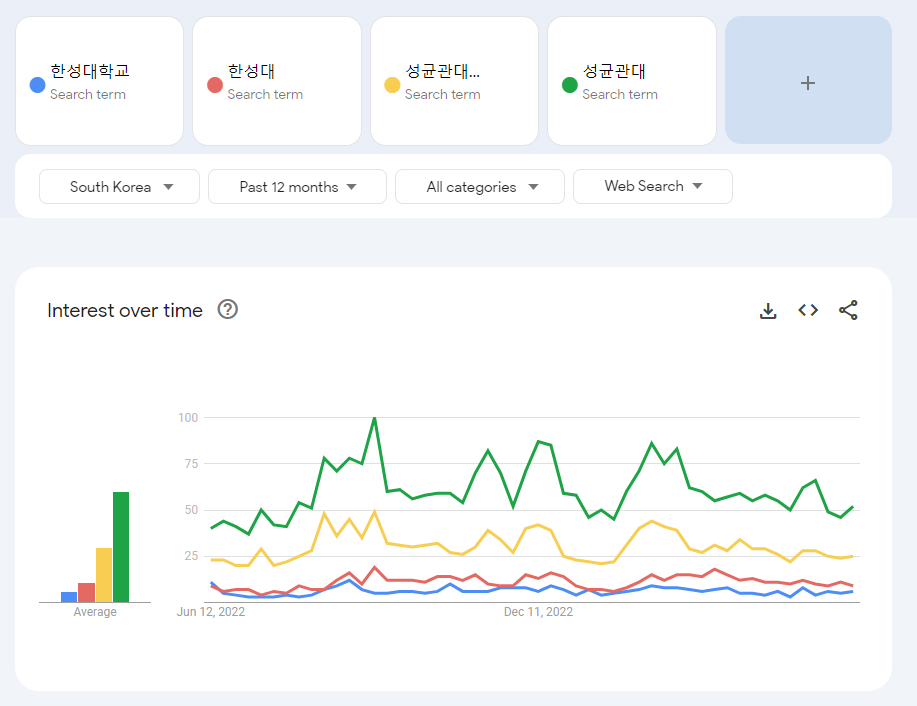

### 획득 대학 전처리
문과와 이과 캠퍼스가 분리된 경희 & 성균관 대학교의 경우 검색량이 서울의 대학 상권에 한정되는 정도가 적을것같아서 제외  
서울대의 경우, 서울대 입구에서부터 가장 가까운 상권까지의 거리가 너무 멀어 제외  
한성대학교의 경우, pytrends의 오류로 인해 비정상적으로 많은 검색량이 추출되어 제외

In [13]:
target_univ = target_univ.drop(target_univ[target_univ['학교명'] == '경희대학교'].index)
target_univ = target_univ.drop(target_univ[target_univ['학교명'] == '성균관대학교'].index)
target_univ = target_univ.drop(target_univ[target_univ['학교명'] == '서울대학교'].index)
target_univ = target_univ.drop(target_univ[target_univ['학교명'] == '한성대학교'].index)

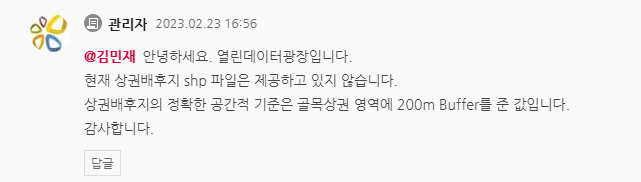

파이썬으로 획득한 좌표는 EPSG 4326(WGS 84" 좌표 시스템)  
데이터베이스에서 제공하는 좌표는 EPSG 5181 (Korea 2000 / Unified CS (transverse mercator))


## 2-1 대학 주소별 좌표 획득

### 대학별 주소 전처리 / 도로명 주소 화
연대 - 서울 서대문구 연세로 50  
건대 - 서울 광진구 능동로 120  
고대 - 서울 성북구 안암로 145  
경희대 - 서울 동대문구 경희대로 26  
성대 - 서울 종로구 성균관로 25-2  

In [14]:
# geopy의 지오코더 객체 생성
geolocator = Nominatim(user_agent='university_geocoder')

# 대학의 주소를 좌표로 변환하여 저장할 리스트
coordinates = []

def preprocess_address(address):
    # 서울특별시를 서울로 변경
    address = re.sub(r'서울특별시', '서울', address)
    
    # 괄호와 그 안에 있는 내용 제거
    address = re.sub(r'\([^)]*\)', '', address)
    
    # 주소 뒤 대학교 이름이 존재하는 경우 지움
    address = re.sub(r'(\s+대학교)$', '', address)
    
    return address.strip()

# 주소를 좌표로 변환하는 함수
def get_coordinates(address):
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None

# 대학의 주소를 좌표로 변환하여 저장할 리스트
coordinates = []

# 대학별 주소를 변경
target_univ.loc[target_univ['학교명'] == '연세대학교', '주소'] = '서울 서대문구 연세로 50'
target_univ.loc[target_univ['학교명'] == '건국대학교', '주소'] = '서울 광진구 능동로 120'
target_univ.loc[target_univ['학교명'] == '고려대학교', '주소'] = '서울 성북구 안암로 145'
target_univ.loc[target_univ['학교명'] == '경희대학교', '주소'] = '서울 동대문구 경희대로 26'
target_univ.loc[target_univ['학교명'] == '숭실대학교', '주소'] = '서울 동작구 상도로 369'
target_univ.loc[target_univ['학교명'] == '세종대학교', '주소'] = '서울 광진구 능동로 209'

# 대학별 주소를 순회하며 좌표를 구함
for index, row in target_univ.iterrows():
    address = row['주소']
    preprocessed_address = preprocess_address(address)
    print(row['학교명']+"의 처리된 주소는"+preprocessed_address)
    coords = get_coordinates(preprocessed_address)
    coordinates.append(coords)

# 좌표를 데이터프레임에 추가
target_univ['EPSG 4326'] = coordinates

# 결과 출력
print(target_univ)


홍익대학교의 처리된 주소는서울 마포구 와우산로 94
중앙대학교의 처리된 주소는서울 동작구 흑석로 84
연세대학교의 처리된 주소는서울 서대문구 연세로 50
건국대학교의 처리된 주소는서울 광진구 능동로 120
고려대학교의 처리된 주소는서울 성북구 안암로 145
한양대학교의 처리된 주소는서울 성동구 왕십리로 222
세종대학교의 처리된 주소는서울 광진구 능동로 209
숭실대학교의 처리된 주소는서울 동작구 상도로 369
      학교명                      주소   행정구   행정동   검색량  \
21  홍익대학교  서울특별시 마포구 와우산로 94(상수동)   마포구   서강동  4147   
11  중앙대학교           서울 동작구 흑석로 84   동작구   흑석동  3913   
8   연세대학교          서울 서대문구 연세로 50  서대문구   신촌동  3730   
25  건국대학교          서울 광진구 능동로 120   광진구   화양동  3715   
28  고려대학교          서울 성북구 안암로 145   성북구   안암동  3657   
19  한양대학교     서울특별시 성동구 왕십리로 222    성동구   사근동  3653   
5   세종대학교          서울 광진구 능동로 209   광진구   군자동  3465   
7   숭실대학교          서울 동작구 상도로 369   동작구  상도1동  2939   

                                   EPSG 4326  
21          (37.55035515, 126.9254432849533)  
11                 (37.5063427, 126.9588765)  
8           (37.56777675, 126.9394028820764)  
25         (37.54184695, 127.07711486219412)  
28  (37.587963099999996, 127.03234540

In [15]:

# 대학별 좌표 정보
coordinates = target_univ['EPSG 4326']

# 대학별로 지도 생성
maps = []
for i, coord in coordinates.iteritems():
    map = folium.Map(location=coord, zoom_start=14)
    folium.Marker(coord, popup=target_univ.loc[i, '학교명']).add_to(map)
    maps.append(map)

# 지도 출력
for map in maps:
    display(map)


### 대학별 좌표 재설정/ 각 상권을 잘 나타내도록
각 대학의 좌표가, 학교 너무 깊은곳에 있어 상권을 인식하지 못하는경우를 처리  
좌표를 학교 입구로 이동한다  
- 건국대 : 37.539461 / 127.072494
- 한양대 : 37.557547 / 127.042033
- 고려대 : 37.587233 / 127.031797
- 연세대 : 37.560227 / 126.936802

In [16]:
# 학교 정보 업데이트
target_univ.loc[target_univ['학교명'] == '건국대학교', 'EPSG 4326'] = '(37.539461, 127.072494)'
target_univ.loc[target_univ['학교명'] == '한양대학교', 'EPSG 4326'] = '(37.557547, 127.042033)'
target_univ.loc[target_univ['학교명'] == '고려대학교', 'EPSG 4326'] = '(37.587233, 127.031797)'
target_univ.loc[target_univ['학교명'] == '연세대학교', 'EPSG 4326'] = '(37.560227, 126.936802)'

In [17]:

# 대상 좌표계 (EPSG 5181)
target_crs = pyproj.CRS.from_epsg(5181)

# 변환할 좌표계 (EPSG 4326)
source_crs = pyproj.CRS.from_epsg(4326)

# 좌표 변환을 위한 Transformer 객체 생성
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)

# 대학의 좌표를 EPSG 5181로 변환하여 저장할 리스트
converted_coordinates = []

# 대학별 좌표를 순회하며 좌표를 변환함
for index, row in target_univ.iterrows():
    coordinates = row['EPSG 4326']
    if coordinates:
        if isinstance(coordinates, str):
            lat, lon = [float(coord) for coord in coordinates.strip('() ').split(", ")]  # 문자열에서 좌표 값을 추출하여 실수로 변환
        else:
            lat, lon = coordinates  # 튜플로부터 추출
        converted_coords = transformer.transform(lon, lat)  # 좌표 변환
        converted_coordinates.append(converted_coords)
    else:
        converted_coordinates.append(None)

# 변환된 좌표를 데이터프레임에 추가
target_univ['EPSG 5181'] = converted_coordinates

# 결과 출력
print(target_univ)


      학교명                      주소   행정구   행정동   검색량  \
21  홍익대학교  서울특별시 마포구 와우산로 94(상수동)   마포구   서강동  4147   
11  중앙대학교           서울 동작구 흑석로 84   동작구   흑석동  3913   
8   연세대학교          서울 서대문구 연세로 50  서대문구   신촌동  3730   
25  건국대학교          서울 광진구 능동로 120   광진구   화양동  3715   
28  고려대학교          서울 성북구 안암로 145   성북구   안암동  3657   
19  한양대학교     서울특별시 성동구 왕십리로 222    성동구   사근동  3653   
5   세종대학교          서울 광진구 능동로 209   광진구   군자동  3465   
7   숭실대학교          서울 동작구 상도로 369   동작구  상도1동  2939   

                           EPSG 4326                                 EPSG 5181  
21  (37.55035515, 126.9254432849533)  (193411.71861110654, 450095.52871793526)  
11         (37.5063427, 126.9588765)    (196363.94377057056, 445208.875813087)  
8            (37.560227, 126.936802)  (194416.17998121885, 451190.45117158745)  
25           (37.539461, 127.072494)   (206406.9396748543, 448886.26726768806)  
28           (37.587233, 127.031797)   (202808.38974357402, 454186.4026803468)  
19           (37.5

## 2.2 각 좌표별 인접한 상권 획득

In [18]:
commercial_area_name_n_location = commercial_area_list[["상권_코드","상권_코드_명","엑스좌표_값","와이좌표_값"]].copy() # 상권 이름 및 좌표 추출
print(commercial_area_name_n_location)

        상권_코드       상권_코드_명  엑스좌표_값  와이좌표_값
0     2110753   시흥동 은행나무사거리  191934  438813
1     2110427    노원 을지대학교병원  206265  459431
2     2110755      동일여자고등학교  192300  439070
3     2110739    시흥3동 우편취급국  191289  438014
4     2111017      송파나루역 3번  210222  445516
...       ...           ...     ...     ...
1666  1001493  동대문패션타운 관광특구  200974  451975
1667  1001494    종로?청계 관광특구  199768  452273
1668  1001495       잠실 관광특구  210191  446339
1669  1001496   강남 마이스 관광특구  205310  445727
1670  1001491      이태원 관광특구  199503  448326

[1671 rows x 4 columns]


In [19]:


univ_near_comm_area =[]

# 대학별로 인접한 상권 추출
for _, univ_row in target_univ.iterrows():
    univ_name = univ_row['학교명']
    univ_coord = univ_row['EPSG 5181']
    
    adjacent_areas = []
    
    for _, com_row in commercial_area_name_n_location.iterrows():
        com_name = com_row['상권_코드_명']
        com_name_code = com_row['상권_코드']
        com_coord = (com_row['엑스좌표_값'], com_row['와이좌표_값'])
        
        # 피타고라스 연산으로 거리 계산
        distance = math.sqrt((univ_coord[0] - com_coord[0]) ** 2 + (univ_coord[1] - com_coord[1]) ** 2)
        
        # 숭실대학교와 중앙대학교는 거리가 600 이내인 경우 인접 상권으로 추가
        # 나머지 대학들은 거리가 700 이내인 경우 인접 상권으로 추가
        if univ_name in ['숭실대학교', '중앙대학교']:
            if distance <= 600:
                adjacent_areas.append((com_name, com_name_code, distance))
        else:
            if distance <= 700:
                adjacent_areas.append((com_name, com_name_code, distance))
    
    # 대학별 인접 상권 정보 출력
    print(f'[{univ_name}]')
    for area in adjacent_areas:
        print(f'- 인접 상권의 이름: {area[0]}, 인접 상권의 거리: {area[2]}')
        univ_near_comm_area.append([univ_name,area[1],area[0]])
    print()
univ_near_comm_area = pd.DataFrame(univ_near_comm_area,columns=['대학명','인접 상권 코드', '인접 상권명'])
print(univ_near_comm_area)

[홍익대학교]
- 인접 상권의 이름: 홍익대, 인접 상권의 거리: 364.0390142594224
- 인접 상권의 이름: 상수역 4번, 인접 상권의 거리: 597.8790546641412
- 인접 상권의 이름: 경의선책거리, 인접 상권의 거리: 696.0822843946539
- 인접 상권의 이름: 상수역 3번, 인접 상권의 거리: 502.7384418242743
- 인접 상권의 이름: 광흥창역 6번, 인접 상권의 거리: 478.59516504692976
- 인접 상권의 이름: 광흥창역 1번, 인접 상권의 거리: 521.0343552219292
- 인접 상권의 이름: 홍대입구역(홍대), 인접 상권의 거리: 418.0750579885096
- 인접 상권의 이름: 상수역(홍대), 인접 상권의 거리: 299.3370808062153
- 인접 상권의 이름: 서교시장, 인접 상권의 거리: 491.59333635010256
- 인접 상권의 이름: 홍대소상공인상점가, 인접 상권의 거리: 454.1136135196015
- 인접 상권의 이름: 홍대 걷고싶은 거리, 인접 상권의 거리: 608.1497489576623

[중앙대학교]
- 인접 상권의 이름: 흑리단길, 인접 상권의 거리: 560.5347341025004
- 인접 상권의 이름: 중앙대학교, 인접 상권의 거리: 196.14077164892913
- 인접 상권의 이름: 중대부중, 인접 상권의 거리: 452.23179371909885
- 인접 상권의 이름: 흑석시장, 인접 상권의 거리: 369.2092661299996

[연세대학교]
- 인접 상권의 이름: 서대문우체국, 인접 상권의 거리: 282.88226658152934
- 인접 상권의 이름: 경의중앙 신촌역, 인접 상권의 거리: 436.9488027069162
- 인접 상권의 이름: 신촌역(신촌역, 신촌로터리), 인접 상권의 거리: 426.4386269913162
- 인접 상권의 이름: 이대 앞 스타트업 상점가, 인접 상권의 거리: 688.6542602399638


### 각 상권별 업종정보 처리

In [20]:
print(commercial_area_store_type_list)

        기준_년_코드  기준_분기_코드 상권_구분_코드 상권_구분_코드_명    상권_코드      상권_코드_명 서비스_업종_코드  \
0          2022         4        U       관광특구  1001496  강남 마이스 관광특구  CS300043   
1          2022         4        U       관광특구  1001496  강남 마이스 관광특구  CS300042   
2          2022         4        U       관광특구  1001496  강남 마이스 관광특구  CS300041   
3          2022         4        U       관광특구  1001496  강남 마이스 관광특구  CS300038   
4          2022         4        U       관광특구  1001496  강남 마이스 관광특구  CS300036   
...         ...       ...      ...        ...      ...          ...       ...   
898063     2020         1        A       골목상권  2110001       이북5도청사  CS200001   
898064     2020         1        A       골목상권  2110001       이북5도청사  CS100010   
898065     2020         1        A       골목상권  2110001       이북5도청사  CS100009   
898066     2020         1        A       골목상권  2110001       이북5도청사  CS100008   
898067     2020         1        A       골목상권  2110001       이북5도청사  CS100001   

       서비스_업종_코드_명  점포_수  유

In [21]:
df = commercial_area_store_type_list[["상권_코드","상권_코드_명","서비스_업종_코드","서비스_업종_코드_명","점포_수"]].copy()
df

,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수
0,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6
1,1001496,강남 마이스 관광특구,CS300042,주유소,1
2,1001496,강남 마이스 관광특구,CS300041,예술품,10
3,1001496,강남 마이스 관광특구,CS300038,자동차부품,10
4,1001496,강남 마이스 관광특구,CS300036,조명용품,14
...,...,...,...,...,...
898063,2110001,이북5도청사,CS200001,일반교습학원,3
898064,2110001,이북5도청사,CS100010,커피-음료,2
898065,2110001,이북5도청사,CS100009,호프-간이주점,2
898066,2110001,이북5도청사,CS100008,분식전문점,3


In [22]:
# 중복된 인덱스를 처리하여 점포 수를 합산
df = df.groupby(['상권_코드', '상권_코드_명', '서비스_업종_코드_명'])['점포_수'].sum().unstack()
# 결과 출력
print(df)

서비스_업종_코드_명                     DVD방   PC방     가구      가방    가전제품  가전제품수리  \
상권_코드   상권_코드_명                                                             
1001491 이태원 관광특구                 NaN   NaN  423.0  1089.0    12.0    39.0   
1001492 명동 남대문 북창동 다동 무교동 관광특구  28.0  16.0  135.0  2550.0   916.0    86.0   
1001493 동대문패션타운 관광특구             9.0  59.0  405.0  1594.0   120.0     NaN   
1001494 종로?청계 관광특구              69.0  39.0   33.0   452.0  1312.0   407.0   
1001495 잠실 관광특구                 41.0  23.0  183.0   399.0   224.0    25.0   
...                              ...   ...    ...     ...     ...     ...   
2130322 고분다리전통시장                 NaN  24.0    NaN     NaN     NaN     NaN   
2130323 둔촌역전통시장                  NaN   NaN    NaN     NaN     NaN     NaN   
2130324 길동복조리시장                  NaN   NaN   12.0     NaN    12.0    36.0   
2130325 명일전통시장                   NaN   NaN    NaN     NaN     NaN     6.0   
2130326 고덕 골목형상점가                NaN  13.0    NaN     2.0     NaN     NaN   

In [23]:
df_filled = df.fillna(0)

In [24]:
# df_filled 데이터프레임의 인덱스를 열로 변환
df_filled.reset_index(inplace=True)

### 대학별 인접 상권 점포 수 & 점포 비율 설정

In [25]:
# 인접 상권 코드를 기준으로 df_filled과 univ_near_comm_area 데이터프레임을 합침
merged_df = pd.merge(df_filled, univ_near_comm_area, left_on='상권_코드', right_on='인접 상권 코드')

# 결과 출력
print(merged_df)


      상권_코드                상권_코드_명   DVD방    PC방     가구     가방   가전제품  가전제품수리  \
0   2110118                왕십리역 9번    0.0    0.0    0.0    0.0    0.0    12.0   
1   2110121                한양대역 4번    0.0    0.0    0.0    0.0    0.0     0.0   
2   2110125              사근동살곶이상점가    0.0   12.0    0.0    0.0   24.0    24.0   
3   2110140               건대입구역 6번    0.0   33.0   12.0    3.0   12.0    16.0   
4   2110141               건대입구역 1번    0.0    0.0   12.0    0.0    0.0    12.0   
5   2110144             어린이대공원역 4번    0.0   12.0    0.0    0.0    0.0     0.0   
6   2110145                 장안초등학교    0.0    0.0    0.0    0.0    0.0     0.0   
7   2110147                능동우편취급국    0.0   12.0   36.0   41.0   35.0     0.0   
8   2110148             어린이대공원역 3번   12.0   24.0    9.0    0.0    0.0     0.0   
9   2110149                  세종대학교    0.0    6.0    0.0    0.0    0.0    18.0   
10  2110155                   광진구청    0.0    0.0   12.0   24.0   16.0    24.0   
11  2110156                 

In [26]:
# 열 순서 변경
new_columns = ['대학명', '인접 상권 코드', '인접 상권명'] + merged_df.columns[3:].tolist()
merged_df = merged_df[new_columns]

# 중복된 열 제거
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# 중복된 열 속성 제거
merged_df.columns = merged_df.columns.where(~merged_df.columns.duplicated(), '')

# 인덱스 변경
merged_df.reset_index(drop=True, inplace=True)

# 결과 출력
print(merged_df)
# merged_df.to_csv('merged_df.csv', index=True,  encoding='euc-kr')

      대학명  인접 상권 코드                 인접 상권명    PC방     가구     가방   가전제품  \
0   한양대학교   2110118                왕십리역 9번    0.0    0.0    0.0    0.0   
1   한양대학교   2110121                한양대역 4번    0.0    0.0    0.0    0.0   
2   한양대학교   2110125              사근동살곶이상점가   12.0    0.0    0.0   24.0   
3   건국대학교   2110140               건대입구역 6번   33.0   12.0    3.0   12.0   
4   건국대학교   2110141               건대입구역 1번    0.0   12.0    0.0    0.0   
5   세종대학교   2110144             어린이대공원역 4번   12.0    0.0    0.0    0.0   
6   세종대학교   2110145                 장안초등학교    0.0    0.0    0.0    0.0   
7   세종대학교   2110147                능동우편취급국   12.0   36.0   41.0   35.0   
8   세종대학교   2110148             어린이대공원역 3번   24.0    9.0    0.0    0.0   
9   세종대학교   2110149                  세종대학교    6.0    0.0    0.0    0.0   
10  건국대학교   2110155                   광진구청    0.0   12.0   24.0   16.0   
11  세종대학교   2110156                 군자역 5번    0.0   52.0   19.0   36.0   
12  고려대학교   2110186                 종암

In [27]:
# 중복된 대학명을 가지는 행을 선택하여 가게 수를 누적
target_univ_stores = merged_df.groupby('대학명').sum()

# 인접 상권 코드와 인접 상권명 열을 제외한 열만 선택
target_univ_stores = target_univ_stores.iloc[:, 3:]

# 결과 출력
print(target_univ_stores)
target_univ_stores.to_csv('target_univ_stores.csv', index=True,  encoding='euc-kr')

          가방   가전제품  가전제품수리  가정용품임대  건축물청소  게스트하우스    고시원  골프연습장  기타법무서비스  \
대학명                                                                         
건국대학교  143.0   95.0    52.0    12.0   13.0     0.0  129.0   12.0     33.0   
고려대학교    2.0   59.0    72.0    12.0   12.0    10.0  113.0    5.0      0.0   
세종대학교   60.0  107.0    18.0     0.0   48.0     0.0   30.0   24.0     16.0   
숭실대학교   22.0   24.0    44.0     9.0   33.0     0.0   46.0   19.0     18.0   
연세대학교  140.0  114.0    30.0    12.0   24.0    34.0  182.0   13.0     12.0   
중앙대학교    0.0   22.0     0.0     0.0    0.0     0.0    0.0    0.0      0.0   
한양대학교   48.0   64.0    48.0    12.0   12.0     0.0   99.0   60.0     12.0   
홍익대학교  395.0  224.0    39.0    52.0   60.0   406.0   55.0   48.0     36.0   

       기타오락장  ...    편의점   피부관리실   한복점   한식음식점    한의원    핸드폰  호프-간이주점     화장품  \
대학명           ...                                                               
건국대학교  257.0  ...  115.0   615.0  10.0  2677.0  192.0  363.0   1580

**각 대학별 상권 점포 수**

In [28]:
target_univ_count_n_stores = target_univ[["학교명","검색량"]].copy()
target_univ_count_n_stores = pd.merge(target_univ_count_n_stores,target_univ_stores,left_on='학교명',right_on='대학명', how='left')
target_univ_count_n_stores.set_index('학교명',inplace = True)
# 각 대학별 총 점포수 계산
target_univ_count_n_stores['총점포수'] = target_univ_count_n_stores.iloc[:, 2:].sum(axis=1)
# 각 대학별 총 상점 수
target_univ_count_n_stores.to_csv("대학별 상권정보 - 점포수.csv",index=True,encoding = "EUC-KR")
target_univ_count_n_stores

,검색량,가방,가전제품,가전제품수리,가정용품임대,건축물청소,게스트하우스,고시원,골프연습장,기타법무서비스,...,피부관리실,한복점,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소,총점포수
학교명,,,,,,,,,,,,,,,,,,,,,
홍익대학교,4147,395.0,224.0,39.0,52.0,60.0,406.0,55.0,48.0,36.0,...,1620.0,47.0,5704.0,192.0,312.0,3417.0,1686.0,553.0,42.0,58072.0
중앙대학교,3913,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,0.0,611.0,24.0,54.0,373.0,76.0,23.0,0.0,4421.0
연세대학교,3730,140.0,114.0,30.0,12.0,24.0,34.0,182.0,13.0,12.0,...,427.0,26.0,3805.0,309.0,366.0,1990.0,671.0,129.0,24.0,26811.0
건국대학교,3715,143.0,95.0,52.0,12.0,13.0,0.0,129.0,12.0,33.0,...,615.0,10.0,2677.0,192.0,363.0,1580.0,689.0,131.0,12.0,23247.0
고려대학교,3657,2.0,59.0,72.0,12.0,12.0,10.0,113.0,5.0,0.0,...,41.0,10.0,1928.0,29.0,110.0,584.0,114.0,70.0,0.0,10000.0
한양대학교,3653,48.0,64.0,48.0,12.0,12.0,0.0,99.0,60.0,12.0,...,219.0,0.0,1592.0,74.0,137.0,477.0,241.0,70.0,17.0,12242.0
세종대학교,3465,60.0,107.0,18.0,0.0,48.0,0.0,30.0,24.0,16.0,...,349.0,4.0,1542.0,120.0,123.0,702.0,296.0,144.0,0.0,13014.0
숭실대학교,2939,22.0,24.0,44.0,9.0,33.0,0.0,46.0,19.0,18.0,...,91.0,0.0,807.0,89.0,55.0,196.0,159.0,74.0,12.0,6717.0


**각 대학별 상권 점포 비율**

In [29]:
target_univ_count_n_stores_ratio = target_univ_count_n_stores.copy()
for column in target_univ_count_n_stores_ratio.columns[1:-1]:
    target_univ_count_n_stores_ratio[column] = (target_univ_count_n_stores_ratio[column] / target_univ_count_n_stores_ratio['총점포수'])*100
target_univ_count_n_stores_ratio.to_csv("대학별 상권정보 - 점포 비율.csv",index=True,encoding = "EUC-KR")
target_univ_count_n_stores_ratio

,검색량,가방,가전제품,가전제품수리,가정용품임대,건축물청소,게스트하우스,고시원,골프연습장,기타법무서비스,...,피부관리실,한복점,한식음식점,한의원,핸드폰,호프-간이주점,화장품,화초,회계사사무소,총점포수
학교명,,,,,,,,,,,,,,,,,,,,,
홍익대학교,4147,0.680190,0.385728,0.067158,0.089544,0.103320,0.699132,0.094710,0.082656,0.061992,...,2.789640,0.080934,9.822290,0.330624,0.537264,5.884075,2.903292,0.952266,0.072324,58072.0
중앙대학교,3913,0.000000,0.497625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.701199,0.000000,13.820403,0.542864,1.221443,8.437005,1.719068,0.520244,0.000000,4421.0
연세대학교,3730,0.522174,0.425199,0.111894,0.044758,0.089515,0.126814,0.678826,0.048488,0.044758,...,1.592630,0.096975,14.191936,1.152512,1.365111,7.422327,2.502704,0.481146,0.089515,26811.0
건국대학교,3715,0.615133,0.408655,0.223685,0.051620,0.055921,0.000000,0.554910,0.051620,0.141954,...,2.645503,0.043016,11.515464,0.825913,1.561492,6.796576,2.963823,0.563514,0.051620,23247.0
고려대학교,3657,0.020000,0.590000,0.720000,0.120000,0.120000,0.100000,1.130000,0.050000,0.000000,...,0.410000,0.100000,19.280000,0.290000,1.100000,5.840000,1.140000,0.700000,0.000000,10000.0
한양대학교,3653,0.392093,0.522790,0.392093,0.098023,0.098023,0.000000,0.808691,0.490116,0.098023,...,1.788923,0.000000,13.004411,0.604476,1.119098,3.896422,1.968633,0.571802,0.138866,12242.0
세종대학교,3465,0.461042,0.822191,0.138313,0.000000,0.368834,0.000000,0.230521,0.184417,0.122945,...,2.681727,0.030736,11.848778,0.922084,0.945136,5.394191,2.274474,1.106501,0.000000,13014.0
숭실대학교,2939,0.327527,0.357302,0.655054,0.133988,0.491291,0.000000,0.684830,0.282864,0.267977,...,1.354771,0.000000,12.014292,1.324996,0.818818,2.917969,2.367128,1.101682,0.178651,6717.0


# 3. 데이터 분석

## 회기분석

### 방법 1 - 일반 선형회기 분석

1. OLS 모델을 통한 회기분석
2. p값이 낮은 원소의 처리
3. 변수 선택 과정 후 다인자 회기분석 진행

In [30]:
table_column_index = target_univ_count_n_stores_ratio.columns
table_column_index

Index(['검색량', '가방', '가전제품', '가전제품수리', '가정용품임대', '건축물청소', '게스트하우스', '고시원',
       '골프연습장', '기타법무서비스', '기타오락장', '네일숍', '노래방', '녹음실', '당구장', '독서실', '동물병원',
       '모터사이클및부품', '모터사이클수리', '문구', '미곡판매', '미용실', '미용재료', '반찬가게', '법무사사무소',
       '변리사사무소', '변호사사무소', '복권방', '볼링장', '부동산중개업', '분식전문점', '비디오/서적임대', '사진관',
       '서적', '섬유제품', '세무사사무소', '세탁소', '수산물판매', '슈퍼마켓', '스포츠 강습', '스포츠클럽',
       '시계및귀금속', '신발', '악기', '안경', '애완동물', '양식음식점', '여관', '여행사', '예술품', '예술학원',
       '완구', '외국어학원', '운동/경기용품', '유아의류', '육류판매', '의료기기', '의류임대', '의약품', '인테리어',
       '일반교습학원', '일반의류', '일반의원', '일식음식점', '자동차미용', '자동차부품', '자동차수리',
       '자전거 및 기타운송장비', '재생용품 판매점', '전자게임장', '전자상거래업', '제과점', '조명용품', '주류도매',
       '주유소', '중고가구', '중고차판매', '중식음식점', '철물점', '청과상', '치과의원', '치킨전문점', '커피-음료',
       '컴퓨터및주변장치판매', '컴퓨터학원', '통번역서비스', '통신기기수리', '패스트푸드점', '편의점', '피부관리실',
       '한복점', '한식음식점', '한의원', '핸드폰', '호프-간이주점', '화장품', '화초', '회계사사무소', '총점포수'],
      dtype='object')

In [31]:


# 결과를 저장할 데이터프레임 생성
result_df = pd.DataFrame(columns=['업종', '상관 정도', 'p값'])

# 속성별로 회귀분석 실행
for var in table_column_index[1:]:
    X = target_univ_count_n_stores_ratio[var]
    y = target_univ_count_n_stores_ratio["검색량"]

    # OLS 모델 생성과 학습
    X = sm.add_constant(X)  # 절편(intercept) 추가
    model = sm.OLS(y, X)
    results = model.fit()
    summary = results.summary()
    table_data = summary.tables[1].data[1:]  # 테이블 데이터 추출
    corr_pvalues = [[var, float(row[3]), float(row[4])] for row in table_data]  # 상관 정도와 p값 추출

    # 결과를 데이터프레임에 추가
    for row in corr_pvalues:
        if row[0] not in result_df['업종'].values:
            result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[2]}, ignore_index=True)
        else:
            index = result_df[result_df['업종'] == row[0]].index[0]
            result_df.loc[index, '상관 정도'] = row[1]
            result_df.loc[index, 'p값'] = row[2]



C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[2]}, ignore_index=True)
C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[2]}, ignore_index=True)
C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[2]}, ignore_index=True)
C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[2]}, ignore_index=True)
C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3848086970.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'업종': row[0], '상관 정도': row[1], 'p값': row[

In [32]:
table_column_index_useful = []
# 'p값' 열을 기준으로 오름차순 정렬
result_df = result_df.sort_values(by='p값', ascending=True)

# 결과 출력
for index, row in result_df.iterrows():
    if row['p값'] < 0.05:
        print(row[0],row[1],row[2])
        table_column_index_useful.append(row[0])
        
table_column_index_useful

자동차수리 -5.058 0.002
스포츠 강습 -4.568 0.004
치킨전문점 -4.501 0.004
수산물판매 -4.35 0.005
당구장 -4.409 0.005
건축물청소 -3.984 0.007
주유소 -3.379 0.015
기타법무서비스 -3.127 0.02
치과의원 -2.998 0.024
미용재료 2.892 0.028
슈퍼마켓 -2.643 0.038
일반교습학원 -2.643 0.038
한의원 -2.596 0.041


['자동차수리',
 '스포츠 강습',
 '치킨전문점',
 '수산물판매',
 '당구장',
 '건축물청소',
 '주유소',
 '기타법무서비스',
 '치과의원',
 '미용재료',
 '슈퍼마켓',
 '일반교습학원',
 '한의원']

In [33]:
# 선형 회기분석

# 종속변수
y = target_univ_count_n_stores_ratio["검색량"]

# 독립변수
X = target_univ_count_n_stores_ratio[table_column_index_useful]

# OLS 모델 생성과 학습
X = sm.add_constant(X)  # 절편(intercept) 추가
model = sm.OLS(y, X)
results = model.fit()

# 회귀분석 결과 출력
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    검색량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                nan
Time:                        23:49:03   Log-Likelihood:                 188.58
No. Observations:                   8   AIC:                            -361.2
Df Residuals:                       0   BIC:                            -360.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1634.1360        inf          0        n

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [34]:
# 다항 회기분석

# 종속변수
y = target_univ_count_n_stores_ratio["검색량"]

# 독립변수
X = target_univ_count_n_stores_ratio[table_column_index_useful]

# 독립변수 다항식 변환
degree = 2  # 다항식 차수 (예: 2차 다항식)
X_poly = sm.add_constant(X)  # 절편(intercept) 추가
for i in range(2, degree + 1):
    X_poly = pd.concat([X_poly, X ** i], axis=1)

# 다항 회귀 모델 생성과 학습
model = sm.OLS(y, X_poly)
results = model.fit()

# 회귀분석 결과 출력
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    검색량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                nan
Time:                        23:49:03   Log-Likelihood:                 197.39
No. Observations:                   8   AIC:                            -378.8
Df Residuals:                       0   BIC:                            -378.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1176.6054        inf          0        n

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


### 방법 2 - 규제화 기법을 사용한 분석

**Lasso 회기분석 모델**

In [35]:


# target_univ_count_n_stores_ratio 데이터프레임 가져오기
df = target_univ_count_n_stores_ratio.drop('총점포수', axis=1).copy()

# 독립변수와 종속변수 분리
X = df.drop('검색량', axis=1)
y = df['검색량']

# 데이터 분할: 훈련 세트와 테스트 세트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 라쏘 회귀 모델 생성 및 학습
lasso = Lasso(alpha=0.1)  # alpha 값은 규제 강도를 조절합니다
lasso.fit(X_train_scaled, y_train)

# 학습된 모델을 통한 예측
y_pred = lasso.predict(X_test_scaled)

# 예측 결과 평가
mse = np.mean((y_pred - y_test) ** 2)
r2 = lasso.score(X_test_scaled, y_test)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 1138.4217448890497
R-squared (R2) Score: 0.9326377665746124


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e+02, tolerance: 7.873e+01
  model = cd_fast.enet_coordinate_descent(


In [36]:


#target_univ_count_n_stores_ratio 데이터프레임 가져오기
df = target_univ_count_n_stores_ratio.drop('총점포수', axis=1).copy()

#독립변수와 종속변수 분리
X = df.drop('검색량', axis=1)
y = df['검색량']

#데이터 분할: 훈련 세트와 테스트 세트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#릿지 회귀 모델 생성 및 학습
ridge = Ridge(alpha=0.1) # alpha 값은 규제 강도를 조절합니다
ridge.fit(X_train_scaled, y_train)

#학습된 모델을 통한 예측
y_pred = ridge.predict(X_test_scaled)

#예측 결과 평가
mse = np.mean((y_pred - y_test) ** 2)
r2 = ridge.score(X_test_scaled, y_test)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 95051.48355898855
R-squared (R2) Score: -4.624348139585122


### 방법 3 - 변수 선택 후 회기분석

In [37]:
# RFE를 활용한 변수 선택


# 종속 변수
y = target_univ_count_n_stores_ratio['검색량']

# 독립 변수
X = target_univ_count_n_stores_ratio.drop('검색량', axis=1)

# RFE를 사용하여 변수 선택
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=6)  # 5개의 변수를 선택
selected_features = rfe.fit_transform(X, y)

# 선택된 변수의 인덱스 확인
selected_indices = rfe.get_support(indices=True)
selected_variables = X.columns[selected_indices]
print("Selected Variables:")
print(selected_variables)


Selected Variables:
Index(['외국어학원', '일반의류', '일반의원', '전자상거래업', '치과의원', '한의원'], dtype='object')


In [38]:
# 종속 변수
y = target_univ_count_n_stores_ratio['검색량']

# 독립 변수
X = target_univ_count_n_stores_ratio[selected_variables]

# 상수(intercept) 추가
X = sm.add_constant(X)

# 선형 회귀 모델 구축
model = sm.OLS(y, X)

# 회귀분석 수행
results = model.fit()

# 회귀분석 결과 요약 정보 출력
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                    검색량   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     95.40
Date:                Tue, 13 Jun 2023   Prob (F-statistic):             0.0782
Time:                        23:49:03   Log-Likelihood:                -32.316
No. Observations:                   8   AIC:                             78.63
Df Residuals:                       1   BIC:                             79.19
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4097.8709    103.156     39.725      0.0

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [39]:


# 다항식 특성 추가
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(selected_features)

# 다항 회귀 모델 구축
model = LinearRegression()

# 회귀분석 수행
results = model.fit(X_poly, y)

# 회귀분석 결과 출력
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# 통계적 유의성 확인

X_poly_with_intercept = sm.add_constant(X_poly)
model_with_intercept = sm.OLS(y, X_poly_with_intercept)
results_with_intercept = model_with_intercept.fit()
print(results_with_intercept.summary())

Intercept: 3810.2112636736842
Coefficients: [-17.09928678   7.38168911  -5.37458385 -14.82165214   2.04734894
   3.85395431 -28.09926807 -71.70865843 -24.90368562 -24.9785026
 -20.27525712 -11.95449156  12.57657875 -18.7486761  -26.96881007
   3.11099755  27.80677671   2.68652357 -11.20186642  -5.89718785
   3.34971875   4.9464733  -14.97483072  -2.24398024   1.10560806
   2.14636604   3.16456339]
                            OLS Regression Results                            
Dep. Variable:                    검색량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                nan
Time:                        23:49:03   Log-Likelihood:                 176.35
No. Observations:                   8   AIC:                            -336.7
Df Residuals:                       0   BIC:  

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [40]:
# Stepwise Selection을 활용한 변수 선택


# 종속 변수
y = target_univ_count_n_stores_ratio['검색량']

# 독립 변수
X = target_univ_count_n_stores_ratio.drop('검색량', axis=1)

# 단계별 선택법을 사용하여 변수 선택
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out=0.1, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        
        # Forward step
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add {best_feature} with p-value {best_pval:.6f}')
        
        # Backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval >= threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature} with p-value {worst_pval:.6f}')
        
        if not changed:
            break
    
    return included

selected_variables = stepwise_selection(X, y)

# 선택된 변수 출력
print("Selected Variables:")
print(selected_variables)


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add 자동차수리 with p-value 0.002315


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add 의약품 with p-value 0.001469


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add 한복점 with p-value 0.001026


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add 인테리어 with p-value 0.000249


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add 자전거 및 기타운송장비 with p-value 0.027953


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add 청과상 with p-value 0.004385


C:\Users\USER\AppData\Local\Temp\ipykernel_23192\3509314805.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Selected Variables:
['자동차수리', '의약품', '한복점', '인테리어', '자전거 및 기타운송장비', '청과상']


In [41]:


# 종속 변수
y = target_univ_count_n_stores_ratio['검색량']

# 독립 변수
X = target_univ_count_n_stores_ratio[selected_variables]

# 상수(intercept) 추가
X = sm.add_constant(X)

# 선형 회귀 모델 구축
model = sm.OLS(y, X)

# 회귀분석 수행
results = model.fit()

# 회귀분석 결과 요약 정보 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    검색량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.296e+09
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           8.40e-06
Time:                        23:49:06   Log-Likelihood:                 40.800
No. Observations:                   8   AIC:                            -67.60
Df Residuals:                       1   BIC:                            -67.04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4399.1385      0.014   3.15e+05   

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [42]:



# 다항식 특성 추가
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(selected_features)

# 다항 회귀 모델 구축
model = LinearRegression()

# 회귀분석 수행
results = model.fit(X_poly, y)

# 회귀분석 결과 출력
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# 통계적 유의성 확인

X_poly_with_intercept = sm.add_constant(X_poly)
model_with_intercept = sm.OLS(y, X_poly_with_intercept)
results_with_intercept = model_with_intercept.fit()
print(results_with_intercept.summary())

Intercept: 3810.2112636736842
Coefficients: [-17.09928678   7.38168911  -5.37458385 -14.82165214   2.04734894
   3.85395431 -28.09926807 -71.70865843 -24.90368562 -24.9785026
 -20.27525712 -11.95449156  12.57657875 -18.7486761  -26.96881007
   3.11099755  27.80677671   2.68652357 -11.20186642  -5.89718785
   3.34971875   4.9464733  -14.97483072  -2.24398024   1.10560806
   2.14636604   3.16456339]
                            OLS Regression Results                            
Dep. Variable:                    검색량   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                nan
Time:                        23:49:06   Log-Likelihood:                 176.35
No. Observations:                   8   AIC:                            -336.7
Df Residuals:                       0   BIC:  

C:\Users\USER\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


# 분석 결과(6월 13일 기준)

### RFE 변수 선택 후 회기분석

**선택 인자**
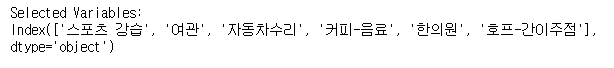

**선형회기 결과**
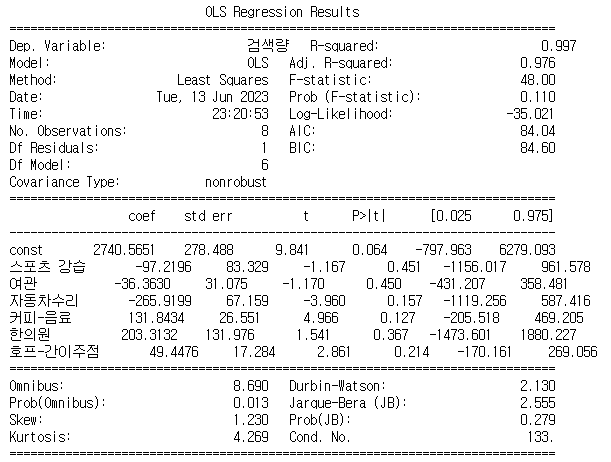

**모델 평가 1**
R-squared 값 : 0.997, 독립 변수들이 종속 변수의 변동을 매우 잘 설명한다는 것을 나타냅니다. 모델의 적합도가 매우 높음을 의미합니다.
Adjusted R-squared 값 : 0.976로, 모델에 사용된 독립 변수들이 적절하게 조정되었음을 보여줍니다.

F-statistic 값 : 48.00이며, 회귀 모델의 유의성을 평가하는데 사용됩니다.   
Prob (F-statistic) 값이 0.110으로 나타나며, 유의수준 0.05보다 크기 때문에 회귀 모델이 통계적으로 유의미하지 않을 수 있습니다.

회귀 계수들의 p-value를 확인해보면, 스포츠 강습, 여관, 자동차수리, 커피-음료, 한의원, 호프-간이주점 변수 중 **자동차수리** 변수의 p-value가 0.157로 유의수준 0.05보다 크기 때문에 통계적으로 유의미하지 않을 수 있습니다.

**모델 평가 2**
Omnibus 검정 : p-value가 0.013으로 나타나며, 잔차가 정규분포를 따른다는 가정을 충족시키지 못합니다.  
이는 잔차에 대한 조금의 의심을 야기할 수 있습니다.
Durbin-Watson 통계량 : 2.130으로 나타나며, 잔차 간의 자기상관을 평가하는 데 사용됩니다.   
일반적으로 2 주변의 값을 가지면 자기상관이 없다고 판단할 수 있습니다.   
이 모델의 경우 자기상관이 거의 없음을 의미합니다.  

Jarque-Bera 통계량 : 2.555이며 ,본 속성은 잔차의 정규성을 검정하는데 사용됩니다.  
일반적으로 정규분포를 따를 경우 해당 통계량은 0 주변의 값을 갖습니다.   
이 모델에서는 2.555로 비교적 정규성을 만족하는 것으로 나타납니다.  

**선형회기 공식**

검색량 = 2740.5651 - 97.2196 * 스포츠 강습 - 36.3630 * 여관 - 265.9199 * 자동차수리 + 131.8434 * 커피-음료 + 203.3132 * 한의원 + 49.4476 * 호프-간이주점

**선형회기 의미**
- 고민사거리 내 더 생겨야한다
  1. 커피 - 음료
  2. 한의원
  3. 호프 - 주점
- 고민사거리 내 줄어야한다
  1. 스포츠 강습원(헬스장..?)
  2. 여관
  3. 자동차수리점

### Stepwise Selection 변수 선택 후 회기분석

**선택 인자**
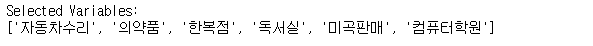

**선형회기 결과**
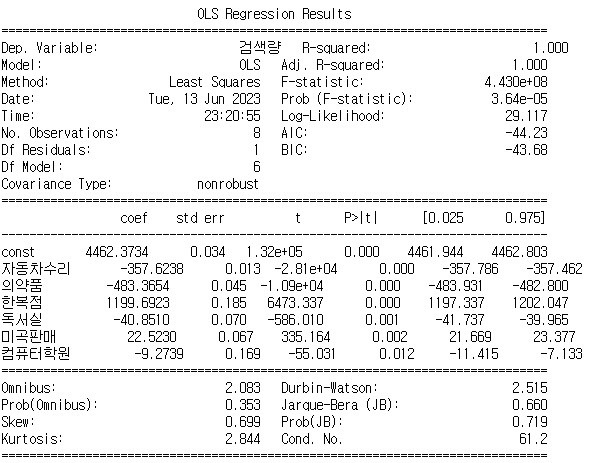

**모델 평가 1**

주어진 OLS(Ordinary Least Squares) 회귀 결과를 보면, 이 모델은 매우 높은 결정 계수(R-squared) 값인 1.000을 가지며, 모형의 적합도가 매우 높음을 나타냅니다.  
즉, 독립 변수들이 종속 변수에 대해 매우 잘 설명하고 있다고 할 수 있습니다.   
조정된 결정 계수(Adj. R-squared) 값도 1.000으로 나타나며, 이는 독립 변수들이 모델에 적합한 것을 추가로 강화시켰음을 의미합니다.

회귀 계수(coefficient) 값들은 각 독립 변수들과 종속 변수 간의 관계를 설명해줍니다. 회귀 계수들은 통계적으로 유의미한지를 나타내는 p-value와 함께 제공됩니다.  
본 모델은 모든 변수의 회귀 계수가 통계적으로 유의미 한 것으로 나타납니다.

**모델 평가 2**

Omnibus 검정 결과 : p-value는 0.353으로 나타나며, 잔차가 정규분포를 따른다는 가정을 충족시키지 못합니다.   
하지만 이 결과는 잔차 분석에 있어서는 큰 문제가 없을 수 있습니다.  

Durbin-Watson 통계량 : 2.515로 나타나며, 잔차 간의 자기상관을 평가하는 데 사용됩니다.  
일반적으로 2 주변의 값을 가지면 자기상관이 없다고 판단할 수 있으며, 이 모델의 경우 자기상관이 거의 없음을 의미합니다.

Jarque-Bera 통계량은 0.660 : 본 속성은 잔차의 정규성을 검정하는데 사용됩니다.   
일반적으로 정규분포를 따를 경우 해당 통계량은 0 주변의 값을 갖습니다.   
이 모델에서는 0.660으로 비교적 정규성을 만족하는 것으로 나타납니다.  

**선형회기 공식**  
검색량 = 4462.3734 - 357.6238 * 자동차수리점 - 483.3654 * 의약품 + 1199.6923 * 한복점 - 40.8510 * 독서실 + 22.5230 * 미곡판매 - 9.2739 * 컴퓨터학원

**선형회기 의미**
- 고민사거리 내 더 생겨야한다
  1. 한복점
  2. 미곡판매(곡식 판매점)
- 고민사거리 내 줄어야한다
  1. 자동차 수리점
  2. 약국
  3. 독서실
  5. 컴퓨터학원